In [8]:
# univariate multi-step cnn for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras import Model, layers
from keras.models import load_model, model_from_json

In [9]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test


In [10]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [11]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [12]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [13]:
# train the model
def build_and_train_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 20, 4
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [14]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [20]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_and_train_model(train, n_input)
    model.save('models/ConvNet_Univariate_Input_Model_14daysInput.h5')

    # architecture to JSON, weights to HDF5
    model.save_weights('models/ConvNet_Univariate_Input_Model_Weights_14daysInput.h5')
    with open('models/ConvNet_Univariate_Input_Model_architecture_14daysInput.json', 'w') as f:
            f.write(model.to_json())
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [21]:
def load_pretrained_model(train, test, n_input):
    # architecture and weights from HDF5
    model = load_model('models/ConvNet_Univariate_Input_Model_14daysInput.h5')

    # architecture from JSON, weights from HDF5
    with open('models/ConvNet_Univariate_Input_Model_architecture_14daysInput.json') as f:
        model = model_from_json(f.read())
    model.load_weights('models/ConvNet_Univariate_Input_Model_Weights_14daysInput.h5')
    
    
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

Epoch 1/20
1099/1099 [==============================] - 1s 543us/step - loss: 815145.5301
Epoch 2/20
1099/1099 [==============================] - 0s 277us/step - loss: 285275.9948
Epoch 3/20
1099/1099 [==============================] - 0s 305us/step - loss: 281221.7141
Epoch 4/20
1099/1099 [==============================] - 0s 346us/step - loss: 279808.0246
Epoch 5/20
1099/1099 [==============================] - 0s 317us/step - loss: 275529.0319
Epoch 6/20
1099/1099 [==============================] - 0s 317us/step - loss: 274490.7838
Epoch 7/20
1099/1099 [==============================] - 0s 351us/step - loss: 273366.9458
Epoch 8/20
1099/1099 [==============================] - 0s 332us/step - loss: 271466.6756
Epoch 9/20
1099/1099 [==============================] - 0s 323us/step - loss: 271355.5735
Epoch 10/20
1099/1099 [==============================] - 0s 309us/step - loss: 270510.2988
Epoch 11/20
1099/1099 [==============================] - 1s 558us/step - loss: 269417.3281
Epoch 12

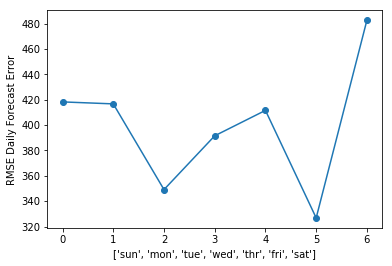

In [17]:

dataset = read_csv('smart meter dataset\household_power_consumption\household_power_consumption_Naive_Forecast_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()

cnn: [402.287] 418.2, 416.7, 349.1, 391.5, 411.6, 326.8, 482.6


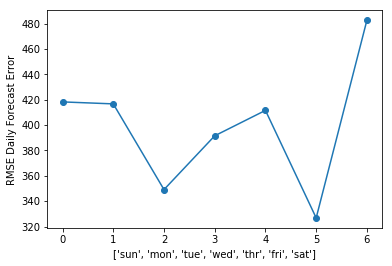

In [18]:
# load pretrained model and get scores
n_input = 7
score, scores = load_pretrained_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()

Epoch 1/20
1092/1092 [==============================] - 1s 646us/step - loss: 1066651.7959
Epoch 2/20
1092/1092 [==============================] - 0s 330us/step - loss: 268975.3263
Epoch 3/20
1092/1092 [==============================] - 0s 334us/step - loss: 261100.4654
Epoch 4/20
1092/1092 [==============================] - 0s 339us/step - loss: 256205.7059
Epoch 5/20
1092/1092 [==============================] - 0s 331us/step - loss: 252035.5132
Epoch 6/20
1092/1092 [==============================] - 0s 345us/step - loss: 248203.1623
Epoch 7/20
1092/1092 [==============================] - 0s 357us/step - loss: 248079.8328
Epoch 8/20
1092/1092 [==============================] - 0s 417us/step - loss: 245099.5319
Epoch 9/20
1092/1092 [==============================] - 1s 467us/step - loss: 244859.9631
Epoch 10/20
1092/1092 [==============================] - 2s 1ms/step - loss: 246030.2466
Epoch 11/20
1092/1092 [==============================] - 2s 2ms/step - loss: 240470.3899
Epoch 12/20

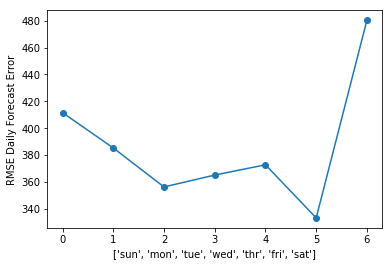

In [22]:
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()

cnn: [388.937] 411.6, 385.3, 356.3, 365.1, 372.8, 333.2, 480.4


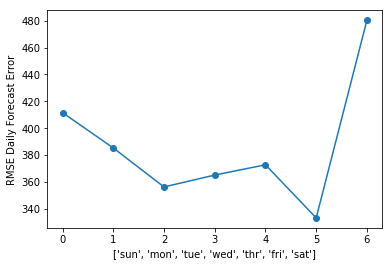

In [23]:
# load pretrained model and get scores
n_input = 14
score, scores = load_pretrained_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()